### III.	Exploratory data analysis (EDA): visualization, statistics (descriptive & inferential), trends  & relationships

**C. Analysis of flight delays: frequency, magnitude, reasons, temporal, spatial and carrier -based analysis** <br>
<ol>
    <li>Understand the relationship between variables
    <li>Delays at departure vs. delays at arrival
    <li>Delays @ Arrival (AD): frequency vs. magnitude
    <li>Flight delays distribution by reason
    <li>Flight delays carrier-based analysis
    <li>Flight delays temporal analysis     
</ol>


####  <font color=blue>Import python libraries and cleaned data file

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import squarify
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import datetime
import time
import random
import os
import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20, 10)

#magic panda line that renders the figure in a notebook
%matplotlib inline

In [2]:
#import file
flights_FINAL=pd.read_csv("/Users/iulialaptop/Documents/0. Career/Python_Projects_Springboard/2015 Flight Delays and Cancellations/Data set/flights_FINAL.csv", low_memory=False)

#reducing the file memory usage by changind the dtypes
dtype = {'YEAR':'int16', 'MONTH':'int8', 'DAY':'int8', 'DAY_OF_WEEK':'int8', 'ARL_CODE':'category', 'DEPARTURE_DELAY':'float32', 'TAXI_OUT':'float32', 'ELAPSED_TIME':'float32', 'AIR_TIME':'float32', 'DISTANCE':'int16','TAXI_IN':'float32','ARRIVAL_DELAY':'float32','DIVERTED':'int8', 'CANCELLED':'int8', 'CANCELLATION_REASON':'category', 'AIR_SYSTEM_DELAY':'float32', 'SECURITY_DELAY':'float32', 'AIRLINE_DELAY':'float32', 'LATE_AIRCRAFT_DELAY':'float32', 'WEATHER_DELAY':'float32'}
flights_FINAL = pd.read_csv("/Users/iulialaptop/Documents/0. Career/Python_Projects_Springboard/2015 Flight Delays and Cancellations/Data set/flights_FINAL.csv", low_memory=False, dtype=dtype)

#airlines file includes the airlines 2-letter code
airlines=pd.read_csv("/Users/iulialaptop/Documents/0. Career/Python_Projects_Springboard/2015 Flight Delays and Cancellations/Data set/airlines.csv")

#drop a few columns I know I will not use
flights_FINAL=flights_FINAL.drop(columns=['YEAR','LATITUDE_org', 'LONGITUDE_org','LATITUDE_dst','LONGITUDE_dst','COUNTRY_org','COUNTRY_dst'])

In [3]:
flights_FINAL['Date']=pd.to_datetime(flights_FINAL['Date'])

In [4]:
#summary table
pd.concat([flights_FINAL.dtypes,
           flights_FINAL.count(),
           flights_FINAL.nunique(),
           flights_FINAL.isnull().sum(),
           round(100 * flights_FINAL.isnull().sum()/len(flights_FINAL),1)], 
              axis=1).rename(columns={0:'Dtype',1:'Non-null counts',2:'Unique values',3:'Missing Nulls',4:'Missing (%)'})

,Dtype,Non-null counts,Unique values,Missing Nulls,Missing (%)
MONTH,int8,5819079,12,0,0.0
DAY,int8,5819079,31,0,0.0
DAY_OF_WEEK,int8,5819079,7,0,0.0
ARL_CODE,category,5819079,14,0,0.0
SCHEDULED_DEPARTURE,object,5819079,1321,0,0.0
DEPARTURE_TIME,object,5732926,1440,86153,1.5
DEPARTURE_DELAY,float32,5732926,1217,86153,1.5
TAXI_OUT,float32,5730032,184,89047,1.5
WHEELS_OFF,object,5730032,1440,89047,1.5
SCHEDULED_TIME,float64,5819073,550,6,0.0


In [5]:
#drop unneccessary columns
flights_2=flights_FINAL.drop(columns=['DIVERTED','CANCELLED','CANCELLATION_REASON'])
#drop rows with null values fopr delays at arrival
flights_2=flights_2[flights_2['ARRIVAL_DELAY'].notnull()].reset_index(drop=True)

In [6]:
airlines['ARL_combo']=airlines['IATA_CODE'] + '_' + airlines['AIRLINE']

#### <font color=blue>1. Understand the relationship between variables  - Correlation matrix

In [7]:
#create a dictionary for the airlines 
ARL_dictionary = airlines.set_index('ARL_combo')['IATA_CODE'].to_dict()
ARL_dictionary

{'UA_United Air Lines Inc.': 'UA',
 'AA_American Airlines Inc.': 'AA',
 'US_US Airways Inc.': 'US',
 'F9_Frontier Airlines Inc.': 'F9',
 'B6_JetBlue Airways': 'B6',
 'OO_Skywest Airlines Inc.': 'OO',
 'AS_Alaska Airlines Inc.': 'AS',
 'NK_Spirit Air Lines': 'NK',
 'WN_Southwest Airlines Co.': 'WN',
 'DL_Delta Air Lines Inc.': 'DL',
 'EV_Atlantic Southeast Airlines': 'EV',
 'HA_Hawaiian Airlines Inc.': 'HA',
 'MQ_American Eagle Airlines Inc.': 'MQ',
 'VX_Virgin America': 'VX'}

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0.5, 0, 'MONTH'),
  Text(1.5, 0, 'DAY'),
  Text(2.5, 0, 'DAY_OF_WEEK'),
  Text(3.5, 0, 'DEPARTURE_DELAY'),
  Text(4.5, 0, 'TAXI_OUT'),
  Text(5.5, 0, 'SCHEDULED_TIME'),
  Text(6.5, 0, 'ELAPSED_TIME'),
  Text(7.5, 0, 'AIR_TIME'),
  Text(8.5, 0, 'DISTANCE'),
  Text(9.5, 0, 'TAXI_IN'),
  Text(10.5, 0, 'ARRIVAL_DELAY'),
  Text(11.5, 0, 'AIR_SYSTEM_DELAY'),
  Text(12.5, 0, 'SECURITY_DELAY'),
  Text(13.5, 0, 'AIRLINE_DELAY'),
  Text(14.5, 0, 'LATE_AIRCRAFT_DELAY'),
  Text(15.5, 0, 'WEATHER_DELAY')])

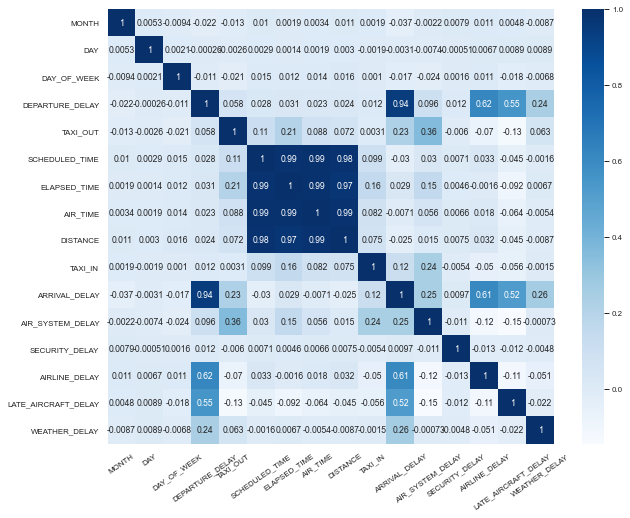

In [8]:
#create a heatmap to indentify the variables that corelate
plt.figure(figsize=(10,8))
sns.set_context('paper',font_scale=0.9)

flights_mx=flights_2.corr()
sns.heatmap(flights_mx, annot=True, cmap='Blues')
plt.xticks(rotation=35)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'DEPARTURE_DELAY'),
  Text(1, 0, 'ARRIVAL_DELAY'),
  Text(2, 0, 'AIRLINE_DELAY'),
  Text(3, 0, 'LATE_AIRCRAFT_DELAY'),
  Text(4, 0, 'WEATHER_DELAY'),
  Text(5, 0, 'AIR_SYSTEM_DELAY'),
  Text(6, 0, 'TAXI_OUT'),
  Text(7, 0, 'SECURITY_DELAY'),
  Text(8, 0, 'DAY'),
  Text(9, 0, 'DAY_OF_WEEK'),
  Text(10, 0, 'TAXI_IN'),
  Text(11, 0, 'MONTH'),
  Text(12, 0, 'DISTANCE'),
  Text(13, 0, 'AIR_TIME'),
  Text(14, 0, 'SCHEDULED_TIME'),
  Text(15, 0, 'ELAPSED_TIME')])

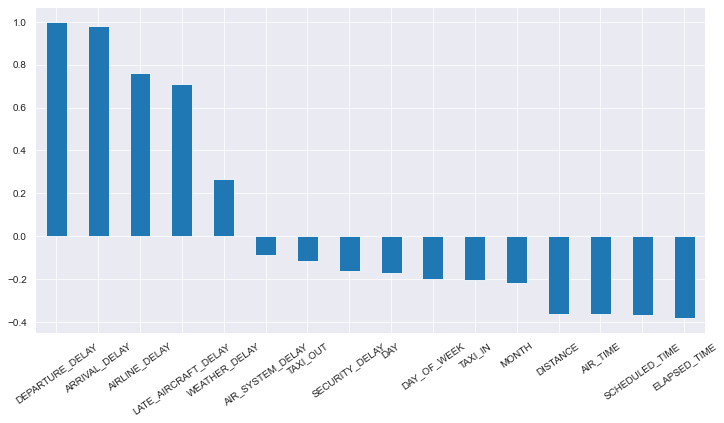

In [9]:
#create a barplot for correlated features
plt.figure(figsize=(12,6))
correlated_df=flights_mx.corr()
correlated_df=correlated_df.sort_values('DEPARTURE_DELAY', ascending=False)
correlated_df['DEPARTURE_DELAY'].plot(kind='bar', fontsize=10)
plt.xticks(rotation=35)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'DEPARTURE_DELAY'),
  Text(1.5, 0, 'ARRIVAL_DELAY'),
  Text(2.5, 0, 'AIR_SYSTEM_DELAY'),
  Text(3.5, 0, 'SECURITY_DELAY'),
  Text(4.5, 0, 'AIRLINE_DELAY'),
  Text(5.5, 0, 'LATE_AIRCRAFT_DELAY'),
  Text(6.5, 0, 'WEATHER_DELAY')])

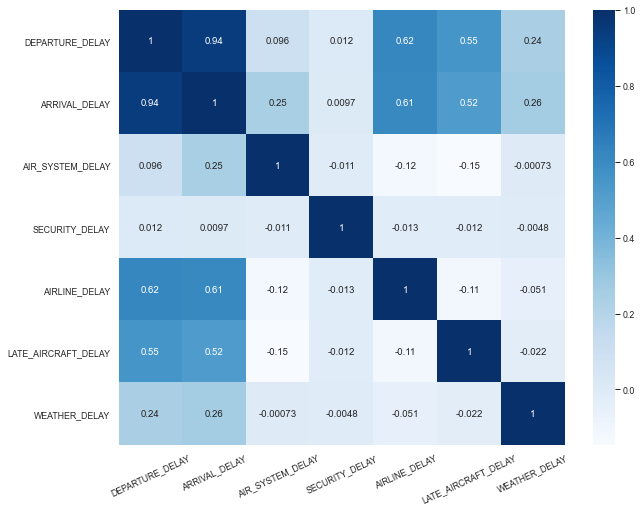

In [10]:
#narrow down the variables & create a pair plot to show the regression plots
#extract a few columns of interest to narrow the data frame
flights_short=flights_2[['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]
plt.figure(figsize=(10,8))
sns.set_context('paper',font_scale=1)

#create a table of correlations
flights_mx_short=flights_short.corr()

#create a heat map
sns.heatmap(flights_mx_short, annot=True, cmap='Blues')
plt.xticks(rotation=25)

Text(0, 0.5, 'R2')

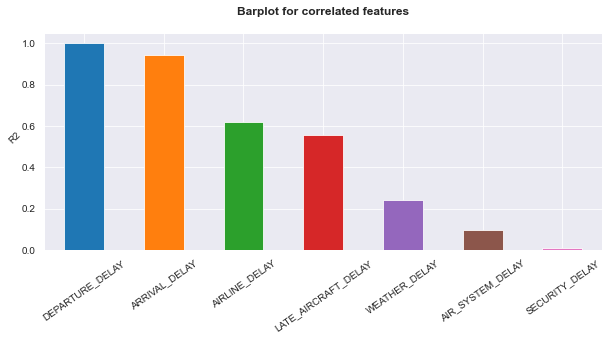

In [11]:
#create a barplot for correlated features
plt.figure(figsize=(10, 4))
correlated_df = flights_short.corr()
correlated_df = correlated_df.sort_values('DEPARTURE_DELAY', ascending=False)
correlated_df['DEPARTURE_DELAY'].plot(
    kind='bar', fontsize=10, color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'])
plt.xticks(rotation=35)
plt.title('Barplot for correlated features\n',size=12, fontweight='bold')
plt.ylabel('R2', rotation=45)

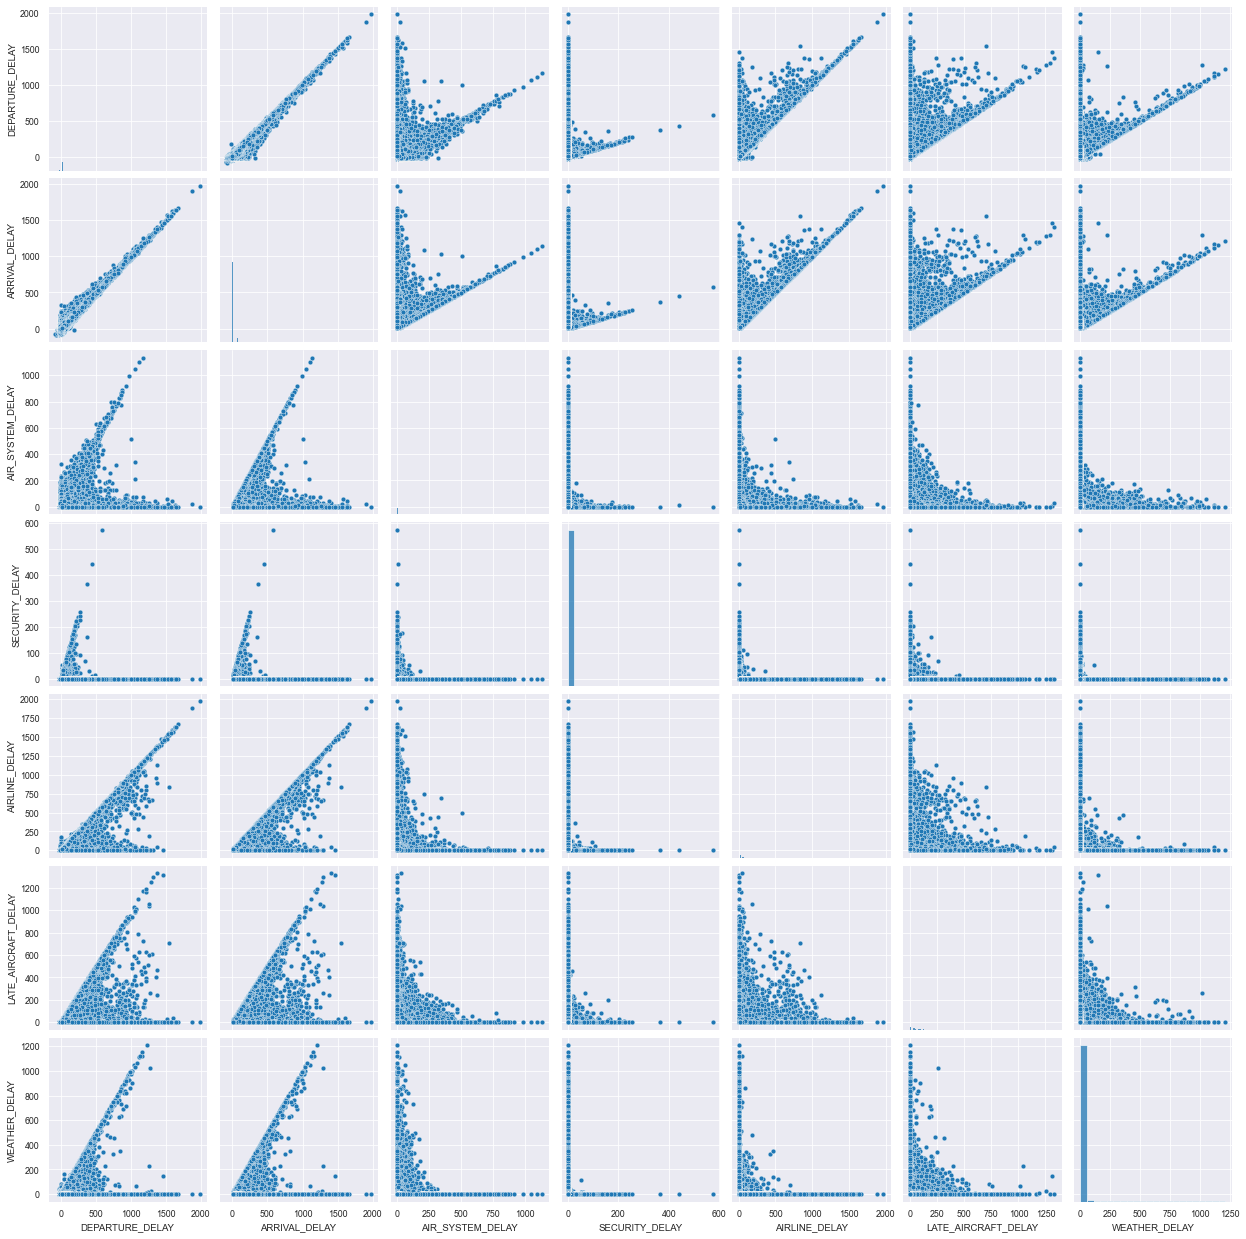

In [12]:
# create a pair plot
sns.pairplot(flights_short)

#### <font color=blue>2. Delays at departure vs. delays at arrival

##### Regression plots of delays

Text(12.574540888888905, 0.5, 'Minutes')

<Figure size 288x288 with 0 Axes>

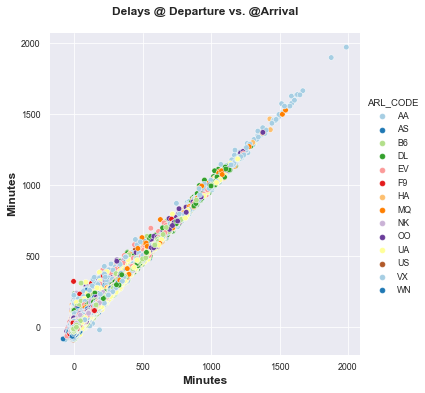

In [13]:
#regression plot for delays at departure vs. delays at arrival
plt.figure(figsize=(4,4))
sns.set_context('paper',font_scale=1)
sns.relplot(x='DEPARTURE_DELAY', y='ARRIVAL_DELAY',
            kind='scatter', data=flights_2, hue='ARL_CODE', palette='Paired', s=30)
plt.title('Delays @ Departure vs. @Arrival\n',size=12, fontweight='bold')
plt.xlabel('Minutes',size=12, fontweight='bold')
plt.ylabel('Minutes',size=12, fontweight='bold')

Text(257.2005440277778, 0.5, 'Minutes')

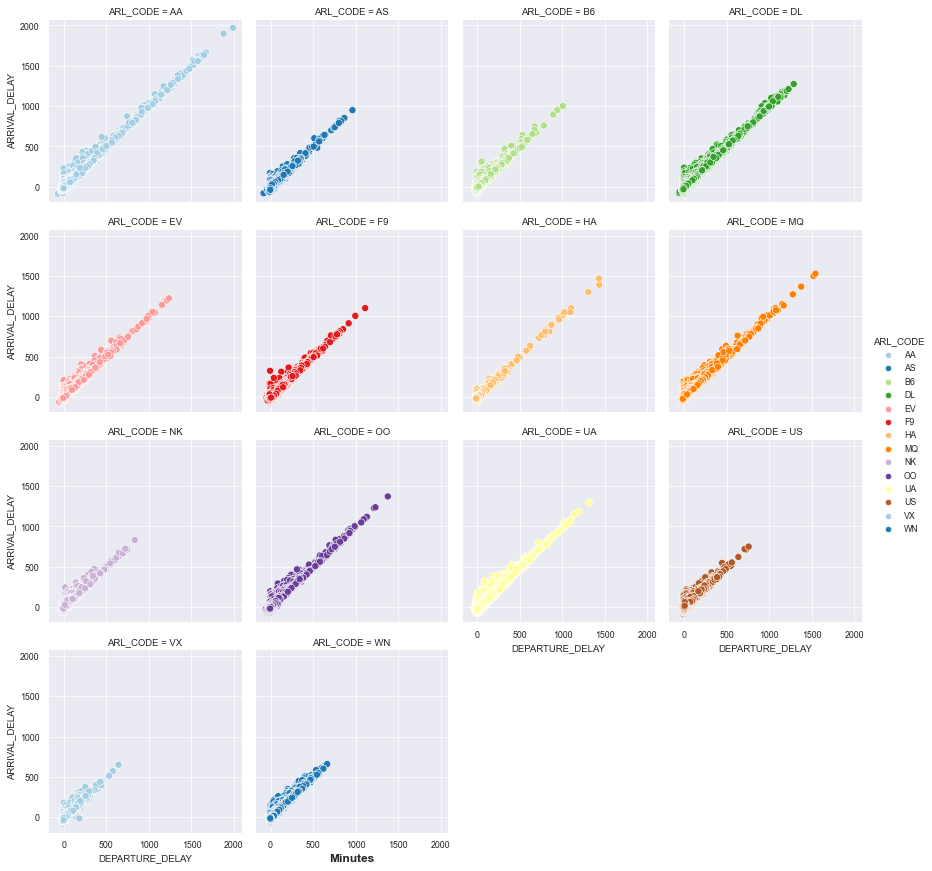

In [14]:
# create regression plots
sns.set_context('paper',font_scale=1)
sns.relplot(x='DEPARTURE_DELAY', y='ARRIVAL_DELAY',
            kind='scatter', data=flights_2, hue='ARL_CODE', palette='Paired', s=50,
           col='ARL_CODE', col_wrap=4, height=3)
plt.xlabel('Minutes',size=12, fontweight='bold')
plt.ylabel('Minutes',size=12, fontweight='bold')

##### Boxplots of delays

In [15]:
flights_2['ARRIVAL_DELAY'].sort_values()

1420147     -87.0
1049837     -87.0
309817      -82.0
4448561     -81.0
1783910     -81.0
            ...  
5705765    1636.0
5184666    1638.0
4018085    1665.0
3334762    1898.0
331026     1971.0
Name: ARRIVAL_DELAY, Length: 5714008, dtype: float32

Text(0.5, 1.0, 'Distribution of delays at Departure\n')

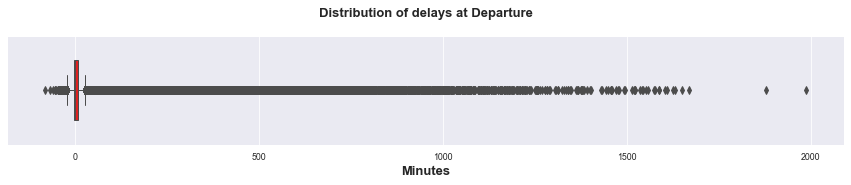

In [16]:
#create box plot for delays at departure
plt.figure(figsize=(15,2))
sns.boxplot(x='DEPARTURE_DELAY', data=flights_2, linewidth=1, width=0.55, color='red')
plt.xlabel('Minutes',size=13, fontweight='bold')
plt.title('Distribution of delays at Departure\n',size=13, fontweight='bold')

Text(0.5, 1.0, 'Distribution of delays at Arrival\n')

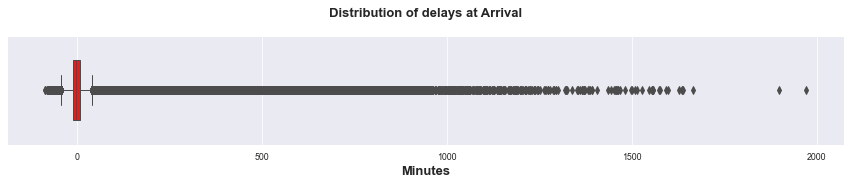

In [17]:
#create box plot for delays at arrival (AD)
plt.figure(figsize=(15,2))
sns.boxplot(x='ARRIVAL_DELAY', data=flights_2, linewidth=1, width=0.55, color='red')
plt.xlabel('Minutes',size=13, fontweight='bold')
plt.title('Distribution of delays at Arrival\n',size=13, fontweight='bold')

#### <font color=blue>3. 2015 Delays at Departure (DD): frequency vs. magnitude

In [18]:
# what is the % distribtuion of delays@arrival; create 3 bins: < 0 (early flights), no delays (=0), and > 0 (positive delays)
conditions=[(flights_2['DEPARTURE_DELAY']<0),
           (flights_2['DEPARTURE_DELAY']==0),
           (flights_2['DEPARTURE_DELAY']>0),]
values=['DD_N','DD_Z','DD_P']

flights_2['DD_NZP']=np.select(conditions, values)

In [19]:
# create 5 bins of delays at arrival: < 0 (early flights), no delays (=0),0' to 15'(small delays considered on-time), 15' to 45' (medium delays), & >45' (large delays)
conditions=[(flights_2['DEPARTURE_DELAY']<0),
           (flights_2['DEPARTURE_DELAY']==0),
           (flights_2['DEPARTURE_DELAY']<=15),
           (flights_2['DEPARTURE_DELAY']<=45),
           (flights_2['DEPARTURE_DELAY']>45)]
values=['DD_N','DD_Z','DD_Ps','DD_Pm','DD_Px']

flights_2['DD_NZP_b']=np.select(conditions, values)

##### Understanding the distribution of delays: ECDF plots of Delays at Departure and Arrival

In [20]:
#float formatting
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [21]:
flights_2[['ARRIVAL_DELAY','DEPARTURE_DELAY']].describe(percentiles=[0.1,0.25,0.75,0.95,0.96, 0.97,0.98,0.99])

,ARRIVAL_DELAY,DEPARTURE_DELAY
count,5714008.000,5714008.000
mean,4.407,9.311
std,39.054,36.414
min,-87.000,-82.000
10%,-20.000,-7.000
25%,-13.000,-5.000
50%,-5.000,-2.000
75%,8.000,7.000
95%,66.000,67.000
96%,79.000,79.000


In [22]:
# remove the top 2 outliers
flights_2b=flights_2[flights_2['DEPARTURE_DELAY']!=1988]
flights_2b=flights_2b[flights_2b['DEPARTURE_DELAY']!=1878]

In [23]:
flights_2b['ARRIVAL_DELAY'].sort_values()
flights_2b['DEPARTURE_DELAY'].sort_values()

5547286    -82.000
1420147    -68.000
673212     -61.000
4178166    -56.000
5619924    -55.000
            ...   
1232474   1609.000
3027416   1625.000
5184666   1631.000
5705765   1649.000
4018085   1670.000
Name: DEPARTURE_DELAY, Length: 5714006, dtype: float32

In [24]:
#see the new max value
flights_2b[['ARRIVAL_DELAY','DEPARTURE_DELAY']].describe(percentiles=[0.1,0.25,0.75,0.98])

,ARRIVAL_DELAY,DEPARTURE_DELAY
count,5714006.000,5714006.000
mean,4.406,9.310
std,39.038,36.397
min,-87.000,-82.000
10%,-20.000,-7.000
25%,-13.000,-5.000
50%,-5.000,-2.000
75%,8.000,7.000
98%,121.000,121.000
max,1665.000,1670.000


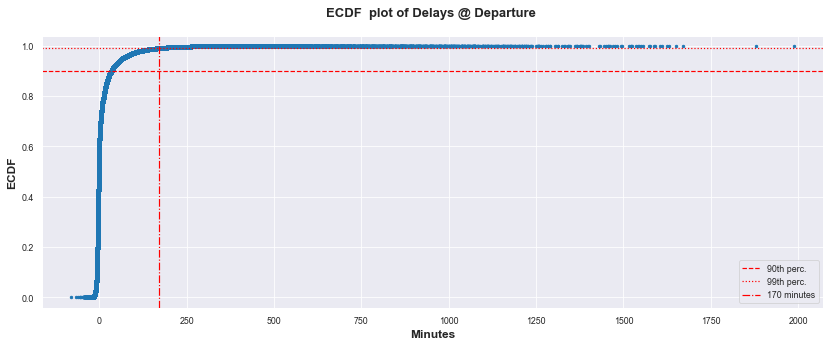

In [25]:
#create an Empirical Cumulative Distribution Function (ECDF)
plt.figure(figsize=(14,5))
x=np.sort(flights_2['DEPARTURE_DELAY'])
y=np.arange(1, len(x)+1) / len(x)
_=plt.plot(x,y, marker='.', linestyle='none')
_=plt.xlabel('Minutes', fontsize=12, fontweight='bold')
_=plt.ylabel('ECDF', fontsize=12, fontweight='bold')
plt.title('ECDF  plot of Delays @ Departure \n', fontsize=13, fontweight='bold')
plt.margins(0.04) #buffer asround the edge
plt.axhline(y=0.90, color='r', linestyle = '--', label='90th perc.')
plt.axhline(y=0.99, color='r', linestyle = 'dotted', label='99th perc.')
plt.axvline(x=170, color='r', linestyle = 'dashdot', label='170 minutes')
plt.legend()

In [26]:
np.percentile(flights_2.DEPARTURE_DELAY, [95,96,97,98,99])

array([ 67.,  79.,  95., 121., 167.])

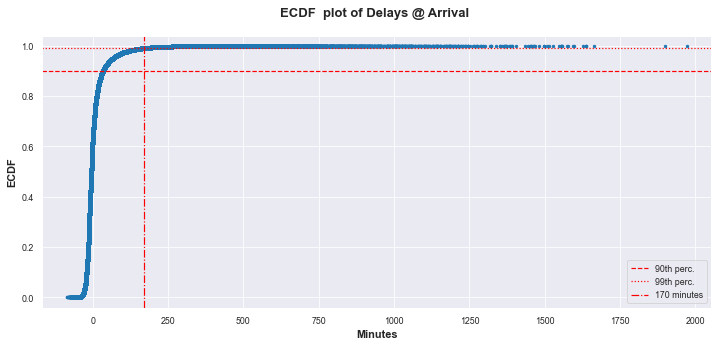

In [27]:
plt.figure(figsize=(12,5))
x=np.sort(flights_2['ARRIVAL_DELAY'])
y=np.arange(1, len(x)+1) / len(x)
_=plt.plot(x,y, marker='.', linestyle='none')
_=plt.xlabel('Minutes', fontsize=11, fontweight='bold')
_=plt.ylabel('ECDF', fontsize=11, fontweight='bold')
plt.title('ECDF  plot of Delays @ Arrival \n', fontsize=13, fontweight='bold')
plt.margins(0.04) #buffer asround the edge
plt.axhline(y=0.90, color='r', linestyle = '--', label='90th perc.')
plt.axhline(y=0.99, color='r', linestyle = 'dotted', label='99th perc.')
plt.axvline(x=170, color='r', linestyle = 'dashdot', label='170 minutes')
plt.legend()

In [28]:
np.percentile(flights_2.ARRIVAL_DELAY, [95,96,97,98,99])

array([ 66.,  79.,  95., 121., 167.])

##### Frequency of delays

In [29]:
#create a series of counts for each bin
flights_DD_NZP= round(flights_2['DD_NZP'].value_counts(normalize=True)*100,1)
flights_DD_NZP

DD_N   57.200
DD_P   37.000
DD_Z    5.700
Name: DD_NZP, dtype: float64

In [30]:
#create a series of counts of each unique value
flights_DD_NZP= flights_2['DD_NZP'].value_counts()
flights_DD_NZP

DD_N    3270517
DD_P    2115049
DD_Z     328442
Name: DD_NZP, dtype: int64

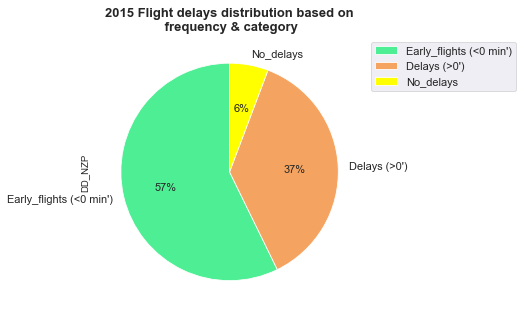

In [31]:
# create a pie chart for FDC counts
labels=["Early_flights (<0 min')","Delays (>0')",'No_delays']

fig, ax=plt.subplots(figsize=(5,5))
my_explode=(0,0,0.1)
my_colors=['#4EEE94', '#F4A460','yellow']
flights_DD_NZP.plot(kind = 'pie', legend=True,radius=1, autopct='%0.0f%%', colors=my_colors, fontsize=11, startangle=90,labels=labels)
plt.title('2015 Flight delays distribution based on\n frequency & category', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1,1),fontsize=11)

In [32]:
#create a series of counts of each unique value
flights_DD_NZP_b= flights_2['DD_NZP_b'].value_counts()
flights_DD_NZP_b

DD_N     3270517
DD_Ps    1103462
DD_Pm     571825
DD_Px     439762
DD_Z      328442
Name: DD_NZP_b, dtype: int64

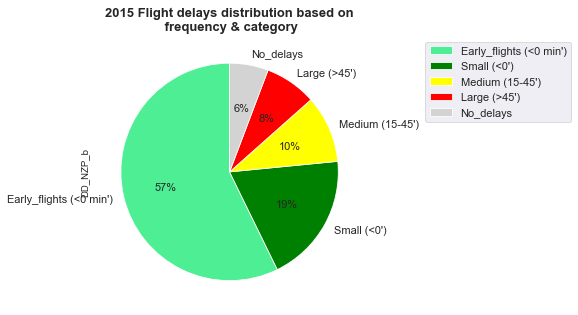

In [33]:
# create a pie chart for FDC counts
labels=["Early_flights (<0 min')","Small (<0')","Medium (15-45')","Large (>45')",'No_delays']

fig, ax=plt.subplots(figsize=(5,5))
my_explode=(0,0,0.1)
my_colors=['#4EEE94', 'green','yellow','red','lightgray']
flights_DD_NZP_b.plot(kind = 'pie', legend=True,radius=1, autopct='%0.0f%%', colors=my_colors, fontsize=11, startangle=90,labels=labels)
plt.title('2015 Flight delays distribution based on\n frequency & category', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1.2,1),fontsize=11)

##### Magnitude of delays

In [34]:
# stats for the 3 arrival delay bins
DD_3b=flights_2.groupby('DD_NZP')['DEPARTURE_DELAY'].describe().reset_index()
DD_3b

,DD_NZP,count,mean,std,min,25%,50%,75%,max
0,DD_N,3270517.000,-4.799,3.050,-82.000,-6.000,-4.000,-2.000,-1.000
1,DD_P,2115049.000,32.487,52.915,1.000,5.000,14.000,38.000,1988.000
2,DD_Z,328442.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Text(0, 0.5, 'Minutes')

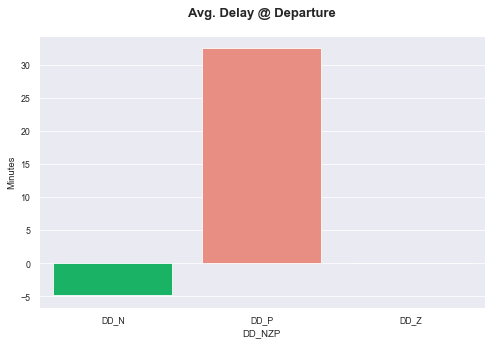

In [35]:
#avg delay bar chart comparison
plt.figure(figsize=(8,5))
DD_clors3={'DD_N':'#00CD66','DD_P':'salmon', 'DD_Z':'yellow'}
sns.barplot(x='DD_NZP', y='mean', data=DD_3b, palette=DD_clors3)
plt.title('Avg. Delay @ Departure\n', fontsize=13, fontweight='bold')
plt.ylabel('Minutes')

In [36]:
# stats for the 3 arrival delay bins without the 2 high outliers
DD_3bb=flights_2b.groupby('DD_NZP')['DEPARTURE_DELAY'].describe().reset_index()
DD_3bb

,DD_NZP,count,mean,std,min,25%,50%,75%,max
0,DD_N,3270517.000,-4.799,3.050,-82.000,-6.000,-4.000,-2.000,-1.000
1,DD_P,2115047.000,32.486,52.883,1.000,5.000,14.000,38.000,1670.000
2,DD_Z,328442.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


> * the average for the early flights is 13'
> * the average for the delays > 0' is about half an hour (33 min.)

In [37]:
# stats for the 5 arrival delay bins
DD_5b=flights_2.groupby('DD_NZP_b')['DEPARTURE_DELAY'].describe().reset_index()
DD_5b

,DD_NZP_b,count,mean,std,min,25%,50%,75%,max
0,DD_N,3270517.000,-4.799,3.050,-82.000,-6.000,-4.000,-2.000,-1.000
1,DD_Pm,571825.000,27.221,8.408,16.000,20.000,26.000,34.000,45.000
2,DD_Ps,1103462.000,6.217,4.238,1.000,2.000,5.000,9.000,15.000
3,DD_Px,439762.000,105.478,79.003,46.000,59.000,81.000,123.000,1988.000
4,DD_Z,328442.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [38]:
# stats for the 5 arrival delay bins w/o the TWO outliers
DD_5bb=flights_2b.groupby('DD_NZP_b')['DEPARTURE_DELAY'].describe().reset_index()
DD_5bb

,DD_NZP_b,count,mean,std,min,25%,50%,75%,max
0,DD_N,3270517.000,-4.799,3.050,-82.000,-6.000,-4.000,-2.000,-1.000
1,DD_Pm,571825.000,27.221,8.408,16.000,20.000,26.000,34.000,45.000
2,DD_Ps,1103462.000,6.217,4.238,1.000,2.000,5.000,9.000,15.000
3,DD_Px,439760.000,105.469,78.910,46.000,59.000,81.000,123.000,1670.000
4,DD_Z,328442.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Text(0, 0.5, 'Minutes')

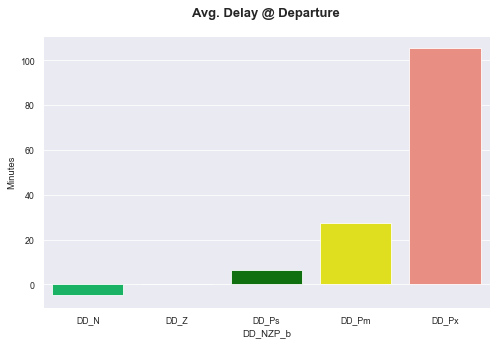

In [39]:
#detailed avg delay bar chart comparison
plt.figure(figsize=(8,5))
DD_clors5={'DD_N':'#00CD66','DD_Z':'black','DD_Ps':'green','DD_Pm':'yellow','DD_Px':'salmon', }
sns.barplot(x='DD_NZP_b', y='mean', data=DD_5b, palette=DD_clors5, order=DD_5b.sort_values('mean').DD_NZP_b)
plt.title('Avg. Delay @ Departure\n', fontsize=13, fontweight='bold')
plt.ylabel('Minutes')

> * the average for the small delays (0' to 15') is about 6 min.
> * the average for the medium delays (15' to 45') is about half an hour (27 min.)
> * the average for the small delays (> 45') is about 106 min.

Text(0.5, 0, 'Minutes')

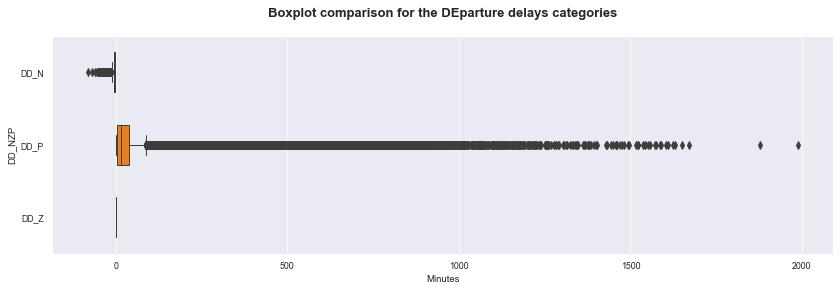

In [40]:
#create 2 df for the early and delayed flights
flights_DDN=flights_2[flights_2['DD_NZP']=='DD_N']
flights_DDP=flights_2[flights_2['DD_NZP']=='DD_P']

# boxplot comparison for the AD categories
plt.figure(figsize=(14,4))

sns.boxplot(y='DD_NZP', x='DEPARTURE_DELAY', data=flights_2, linewidth=1, width=0.55)
plt.title('Boxplot comparison for the DEparture delays categories\n', fontsize=13, fontweight='bold')
ax.set(xlim=(-100, 2000))
plt.xlabel('Minutes')

> * the distribution of the flights with delays > 0' is very large with 2 notable outliers

Text(0.5, 0, 'Minutes')

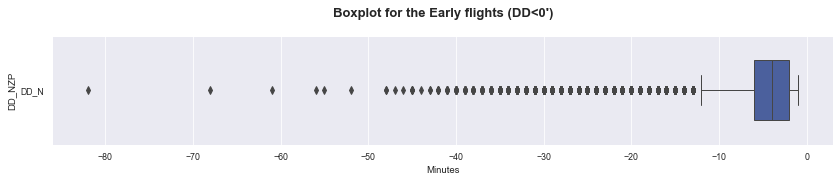

In [41]:
# boxplot for the eraly flights (AD_N; delays<0)
plt.figure(figsize=(14,2))
flights_DDN=flights_2[flights_2['DD_NZP']=='DD_N']
sns.boxplot(y='DD_NZP', x='DEPARTURE_DELAY', data=flights_DDN, linewidth=1, width=0.55, color='#3D59AB')
plt.title("Boxplot for the Early flights (DD<0')\n", fontsize=13, fontweight='bold')
plt.xlabel('Minutes')

In [42]:
#convert the negative values to positive for magnitude comparison chart
flights_2['DEPARTURE_DELAY_p']=flights_2['DEPARTURE_DELAY'].abs()
flights_2['DEPARTURE_DELAY_p']

0         11.000
1          8.000
2          2.000
3          5.000
4          1.000
           ...  
5714003    4.000
5714004    4.000
5714005    9.000
5714006    6.000
5714007   15.000
Name: DEPARTURE_DELAY_p, Length: 5714008, dtype: float32

In [43]:
flights_DD_NZP_s3=flights_2.groupby('DD_NZP')['DEPARTURE_DELAY_p'].sum()
flights_DD_NZP_s3

DD_NZP
DD_N   15696340.000
DD_P   68807144.000
DD_Z          0.000
Name: DEPARTURE_DELAY_p, dtype: float32

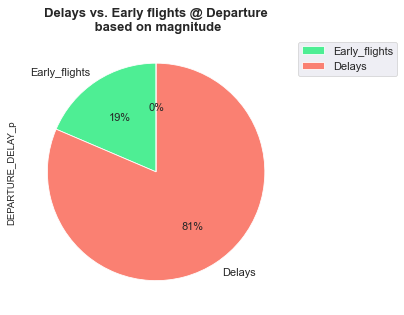

In [44]:
# create a pie chart for delays vs. early flights (magnitude of delays)
labels=['Early_flights','Delays','No_delays']

fig, ax=plt.subplots(figsize=(5,5))
my_colors=['#4EEE94', 'salmon','yellow']
flights_DD_NZP_s3.plot(kind = 'pie', legend=True,radius=1, autopct='%0.0f%%', colors=my_colors, fontsize=11, startangle=90,labels=labels)
plt.title('Delays vs. Early flights @ Departure\n based on magnitude', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1,1),fontsize=11)

In [45]:
# delays broken into 5 bins
flights_DD_NZP_s5=flights_2.groupby('DD_NZP_b')['DEPARTURE_DELAY_p'].sum()
flights_DD_NZP_s5

DD_NZP_b
DD_N    15696340.000
DD_Pm   15565611.000
DD_Ps    6860121.000
DD_Px   46381408.000
DD_Z           0.000
Name: DEPARTURE_DELAY_p, dtype: float32

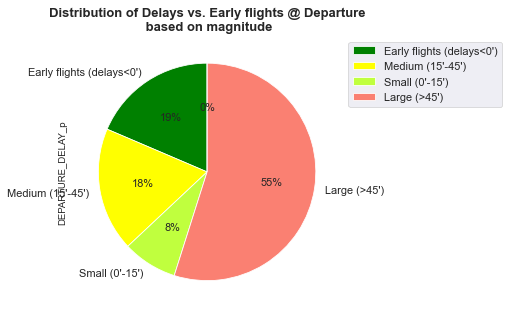

In [46]:
# create a pie chart for delays vs. early flights (magnitude of delays at arrival)
labels=["Early flights (delays<0')","Medium (15'-45')","Small (0'-15')","Large (>45')",'Zero']

fig, ax=plt.subplots(figsize=(5,5))
my_colors=['green','yellow','#C0FF3E','salmon','black']
flights_DD_NZP_s5.plot(kind = 'pie', legend=True,radius=1, autopct='%0.0f%%', colors=my_colors, fontsize=11, startangle=90,labels=labels)
plt.title('Distribution of Delays vs. Early flights @ Departure\n based on magnitude', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1,1),fontsize=11)

Of the total time recorded by delays at arrival in 2015
> * Early flights represent 19% of total time
> * 8% is for flights considered on-time (delays < 15 minutes)
> * 74% of the total time is for the flights that had delays >45'

##### Positive delays (Delays > 0 minutes)

In [47]:
flights_DDP.isnull().sum()

MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
ARL_CODE                     0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME               0
DEPARTURE_DELAY              0
TAXI_OUT                     0
WHEELS_OFF                   0
SCHEDULED_TIME               0
ELAPSED_TIME                 0
AIR_TIME                     0
DISTANCE                     0
WHEELS_ON                    0
TAXI_IN                      0
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME                 0
ARRIVAL_DELAY                0
AIR_SYSTEM_DELAY       1164176
SECURITY_DELAY         1164176
AIRLINE_DELAY          1164176
LATE_AIRCRAFT_DELAY    1164176
WEATHER_DELAY          1164176
Date                         0
Day_name                     0
Month_name                   0
ORG_ARP_FINAL                0
DST_ARP_FINAL                0
ARL_Name                     0
ARP_CODE_org                 0
ARP_Name_org                 0
CITY_org                     0
STATE_or

In [48]:
flights_DDP_mx=flights_2[(flights_2['DD_NZP_b']=='DD_Pm') | (flights_2['DD_NZP_b']=='DD_Px')]
flights_DDP_mx.isnull().sum()

MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
ARL_CODE                    0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME              0
DEPARTURE_DELAY             0
TAXI_OUT                    0
WHEELS_OFF                  0
SCHEDULED_TIME              0
ELAPSED_TIME                0
AIR_TIME                    0
DISTANCE                    0
WHEELS_ON                   0
TAXI_IN                     0
SCHEDULED_ARRIVAL           0
ARRIVAL_TIME                0
ARRIVAL_DELAY               0
AIR_SYSTEM_DELAY       191966
SECURITY_DELAY         191966
AIRLINE_DELAY          191966
LATE_AIRCRAFT_DELAY    191966
WEATHER_DELAY          191966
Date                        0
Day_name                    0
Month_name                  0
ORG_ARP_FINAL               0
DST_ARP_FINAL               0
ARL_Name                    0
ARP_CODE_org                0
ARP_Name_org                0
CITY_org                    0
STATE_org                   0
ARP_CODE_d

In [49]:
DD_5b

,DD_NZP_b,count,mean,std,min,25%,50%,75%,max
0,DD_N,3270517.000,-4.799,3.050,-82.000,-6.000,-4.000,-2.000,-1.000
1,DD_Pm,571825.000,27.221,8.408,16.000,20.000,26.000,34.000,45.000
2,DD_Ps,1103462.000,6.217,4.238,1.000,2.000,5.000,9.000,15.000
3,DD_Px,439762.000,105.478,79.003,46.000,59.000,81.000,123.000,1988.000
4,DD_Z,328442.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [50]:
flights_DDP.groupby('DD_NZP_b')['DEPARTURE_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
DD_NZP_b,,,,,,,,
DD_Pm,571825.000,27.221,8.408,16.000,20.000,26.000,34.000,45.000
DD_Ps,1103462.000,6.217,4.238,1.000,2.000,5.000,9.000,15.000
DD_Px,439762.000,105.478,79.003,46.000,59.000,81.000,123.000,1988.000


In [51]:
flights_DDP_sum=flights_DDP.groupby('DD_NZP_b')['DEPARTURE_DELAY'].sum().sort_values()
flights_DDP_sum

DD_NZP_b
DD_Ps    6860121.000
DD_Pm   15565611.000
DD_Px   46381408.000
Name: DEPARTURE_DELAY, dtype: float32

In [52]:
flights_DDP_sum2=pd.DataFrame(flights_DDP_sum).reset_index()
flights_DDP_sum2

,DD_NZP_b,DEPARTURE_DELAY
0,DD_Ps,6860121.000
1,DD_Pm,15565611.000
2,DD_Px,46381408.000


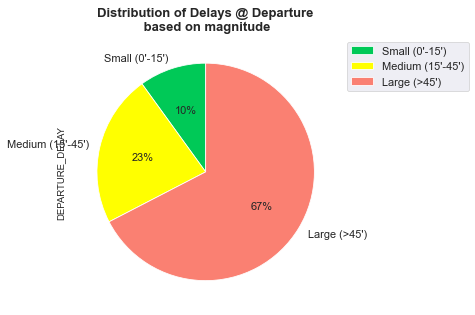

In [53]:
## create a pie chart for delays vs. early flgihsy (magnitude of delays)
labels=["Small (0'-15')","Medium (15'-45')","Large (>45')",'Zero']

fig, ax=plt.subplots(figsize=(5,5))
my_colors=['#00C957','yellow','salmon']
flights_DDP_sum.plot(kind = 'pie', legend=True,radius=1, autopct='%0.0f%%', labels=labels, colors=my_colors, fontsize=11, startangle=90)

plt.title('Distribution of Delays @ Departure\n based on magnitude', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1,1),fontsize=11)

Text(0, 0.5, 'Minutes')

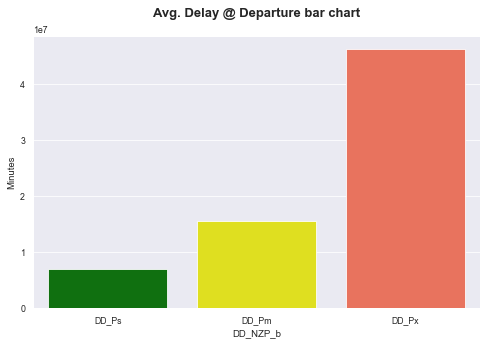

In [54]:
#detailed avg delay bar chart comparison
plt.figure(figsize=(8,5))
DDP_clrs3={'DD_Ps':'green','DD_Pm':'#FFFF00','DD_Px':'#FF6347'}

sns.barplot(x='DD_NZP_b',y='DEPARTURE_DELAY', data=flights_DDP_sum2, palette=DDP_clrs3)
plt.title('Avg. Delay @ Departure bar chart\n', fontsize=13, fontweight='bold')
plt.ylabel('Minutes')

#### <font color=blue>4. Flight delays distribution by reason

In [55]:
Delays_reasons = flights_2[flights_2['WEATHER_DELAY'].notnull()].reset_index(drop=True)

**50% of the recorded delays higher than 0 minutes have a reported reason**
* 1. AIRLINE_DELAY
* 2. LATE_AIRCRAFT_DELAY
* 3. WEATHER_DELAY
* 4. AIR_SYSTEM_DELAY	
* 5. SECURITY_DELAY	

In [56]:
#reason_1
Delays_reasons['AIRLINE_DELAY'].sum()

20172958.0

In [57]:
#reason_2
Delays_reasons['LATE_AIRCRAFT_DELAY'].sum()

24961928.0

In [58]:
#reason_3
Delays_reasons['WEATHER_DELAY'].sum()

3100233.0

In [59]:
#reason_4
Delays_reasons['AIR_SYSTEM_DELAY'].sum()

14335762.0

In [60]:
#reason_5
Delays_reasons['SECURITY_DELAY'].sum()

80985.0

In [61]:
data=[['AIRLINE_D',20172958],['LATE_AIRCRAFT_D',24961928], ['WEATHER_D',3100233], ['AIR_SYSTEM_D',14335762], ['SECURITY_DELAY',80985]]
data

[['AIRLINE_D', 20172958],
 ['LATE_AIRCRAFT_D', 24961928],
 ['WEATHER_D', 3100233],
 ['AIR_SYSTEM_D', 14335762],
 ['SECURITY_DELAY', 80985]]

Text(0.5, 1.0, 'Distribution of Delays by Reason')

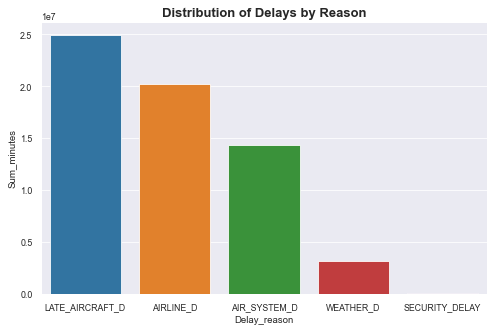

In [62]:
#bar chart comparing the total time lost as of function of reasons
plt.figure(figsize=(8,5))
data=[['AIRLINE_D',20172958],['LATE_AIRCRAFT_D',24961928], ['WEATHER_D',3100233], ['AIR_SYSTEM_D',14335762], ['SECURITY_DELAY',80985]]

D_reasons_sum=pd.DataFrame(data,columns=['Delay_reason','Sum_minutes'])
D_reasons_sum.sort_values('Sum_minutes')
sns.barplot(x='Delay_reason',
            y='Sum_minutes',
            data=D_reasons_sum,
            order=D_reasons_sum.sort_values('Sum_minutes', ascending=False).Delay_reason)
plt.title('Distribution of Delays by Reason', fontsize=13, fontweight='bold')

In [63]:
D_reasons_sum

,Delay_reason,Sum_minutes
0,AIRLINE_D,20172958
1,LATE_AIRCRAFT_D,24961928
2,WEATHER_D,3100233
3,AIR_SYSTEM_D,14335762
4,SECURITY_DELAY,80985


(-1.1298068371484027,
 1.1045067535405588,
 -1.1058677042351563,
 1.100279484126714)

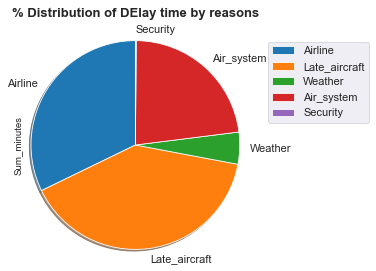

In [64]:
# % distrbution of lost time by reasosn: Security=0.1%, Weather=5%, Air_system=23%, Airline=32%, Later_aircraft=40%
labels=('Airline','Late_aircraft','Weather','Air_system','Security')
D_reasons_sum.plot.pie(legend=True,y='Sum_minutes', radius=1.2, labels=labels, fontsize=11,shadow=True,startangle=90)
plt.title('% Distribution of DElay time by reasons\n', fontsize=13, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.6,1),fontsize=11)
ax.axis('equal')

In [65]:
Delays_cols=flights_2[['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]

In [66]:
Delays_cols.describe()

,DEPARTURE_DELAY,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5714008.000,5714008.000,1063439.000,1063439.000,1063439.000,1063439.000,1063439.000
mean,9.311,4.407,13.481,0.076,18.969,23.473,2.915
std,36.414,39.054,28.036,2.142,48.171,43.111,20.391
min,-82.000,-87.000,0.000,0.000,0.000,0.000,0.000
25%,-5.000,-13.000,0.000,0.000,0.000,0.000,0.000
50%,-2.000,-5.000,2.000,0.000,2.000,3.000,0.000
75%,7.000,8.000,18.000,0.000,19.000,29.000,0.000
max,1988.000,1971.000,1134.000,573.000,1971.000,1331.000,1211.000


#### <font color=blue>5. Flight delays carrier-based analysis

Text(0.5, 0, 'Minutes')

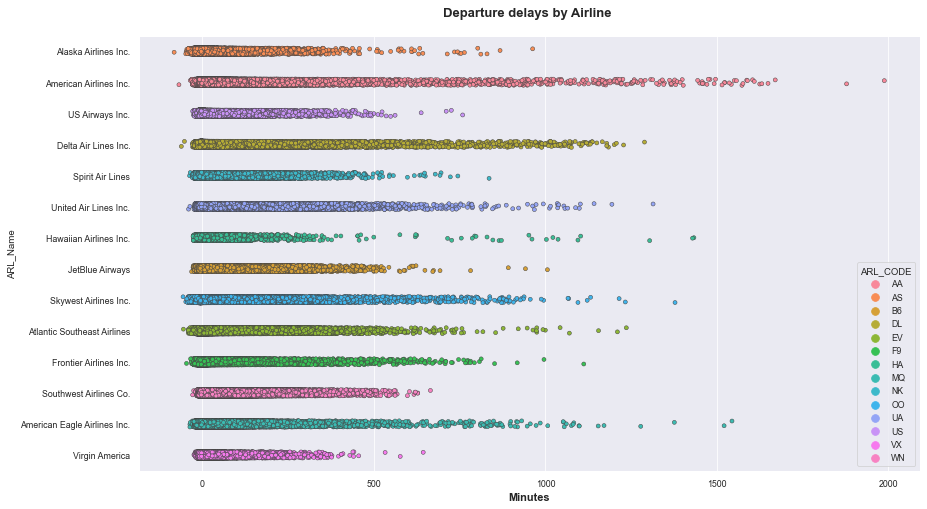

In [67]:
# stripplot for the Arrival Delay categories by airline
plt.figure(figsize=(14,8))
sns.stripplot(y='ARL_Name', x='DEPARTURE_DELAY',
              size=4, data=flights_2,hue='ARL_CODE', linewidth = 0.5,  jitter=True)
plt.title('Departure delays by Airline \n', fontsize=13, fontweight='bold')
plt.xlabel('Minutes', fontsize=11, fontweight='bold')

Text(0.5, 0, 'Minutes')

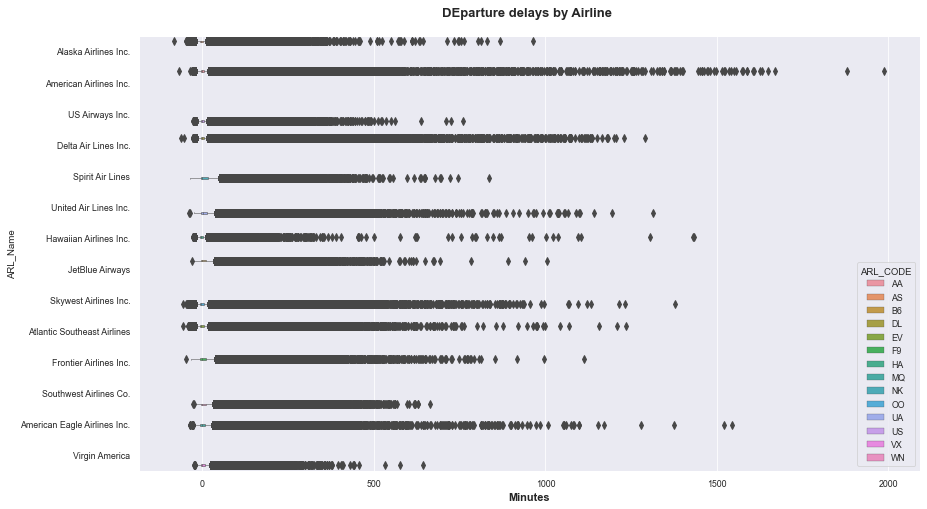

In [68]:
# stripplot for the Arrival Delay categories by airline
plt.figure(figsize=(14,8))
sns.boxplot(y='ARL_Name', x='DEPARTURE_DELAY',
              data=flights_2,hue='ARL_CODE', linewidth = 0.5)
plt.title('DEparture delays by Airline \n', fontsize=13, fontweight='bold')
plt.xlabel('Minutes', fontsize=11, fontweight='bold')

No handles with labels found to put in legend.


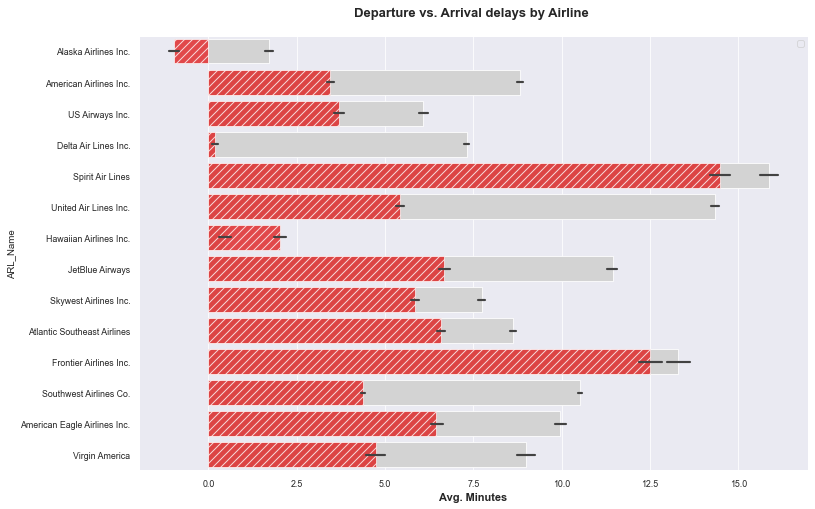

In [69]:
# comparison of delays at departure vs. arrival
fig = plt.figure(1, figsize=(12,8))
ax=sns.barplot(x='DEPARTURE_DELAY', y='ARL_Name', data=flights_2, color='lightgrey')
ax=sns.barplot(x='ARRIVAL_DELAY', y='ARL_Name', data=flights_2, color='red',
               hatch = '///',alpha=0.8)
plt.title('Departure vs. Arrival delays by Airline \n', fontsize=13, fontweight='bold')
plt.xlabel('Avg. Minutes', fontsize=11, fontweight='bold')
plt.legend()

In [70]:
# function for extracting statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean(), 'sum':group.sum()}

# Creation of a dataframe with statitical infos on each airline:
gen_stats = flights_FINAL['DEPARTURE_DELAY'].groupby(flights_FINAL['ARL_CODE']).apply(get_stats).unstack()
gen_stats = gen_stats.sort_values('count')
gen_stats

,min,max,count,mean,sum
ARL_CODE,,,,,
VX,-24.000,644.000,61385.000,9.023,553852.000
HA,-27.000,1433.000,76119.000,0.486,36972.000
F9,-46.000,1112.000,90290.000,13.351,1205449.000
NK,-37.000,836.000,115454.000,15.945,1840887.000
AS,-82.000,963.000,171910.000,1.786,306997.000
US,-35.000,759.000,194825.000,6.141,1196447.000
B6,-31.000,1006.000,262843.000,11.514,3026467.000
MQ,-36.000,1544.000,280282.000,10.125,2837908.000
UA,-40.000,1314.000,509534.000,14.435,7355348.000


In [71]:
# df with delays at departure stats for each airline 
ARL_stats = flights_2['DEPARTURE_DELAY'].groupby(flights_2['ARL_CODE']).apply(get_stats).unstack()
ARL_stats = gen_stats.sort_values('count').reset_index()
ARL_stats

,ARL_CODE,min,max,count,mean,sum
0,VX,-24.000,644.000,61385.000,9.023,553852.000
1,HA,-27.000,1433.000,76119.000,0.486,36972.000
2,F9,-46.000,1112.000,90290.000,13.351,1205449.000
3,NK,-37.000,836.000,115454.000,15.945,1840887.000
4,AS,-82.000,963.000,171910.000,1.786,306997.000
5,US,-35.000,759.000,194825.000,6.141,1196447.000
6,B6,-31.000,1006.000,262843.000,11.514,3026467.000
7,MQ,-36.000,1544.000,280282.000,10.125,2837908.000
8,UA,-40.000,1314.000,509534.000,14.435,7355348.000
9,EV,-55.000,1274.000,557294.000,8.716,4857338.000


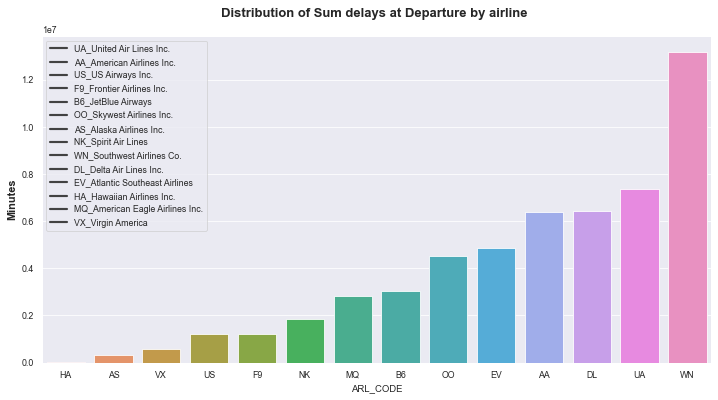

In [72]:
#how airlines compared in terms of lost time (sum of minutes) at departure
plt.figure(figsize=(12,6))

ax=sns.barplot(x='ARL_CODE', y='sum', data=ARL_stats,
           order=ARL_stats.sort_values('sum', ascending=True).ARL_CODE)
plt.title('Distribution of Sum delays at Departure by airline \n', fontsize=13, fontweight='bold')
plt.ylabel('Minutes', fontsize=11, fontweight='bold')
plt.legend(ARL_dictionary)

In [73]:
ARL_stats['mean'].mean()

9.012499121682984

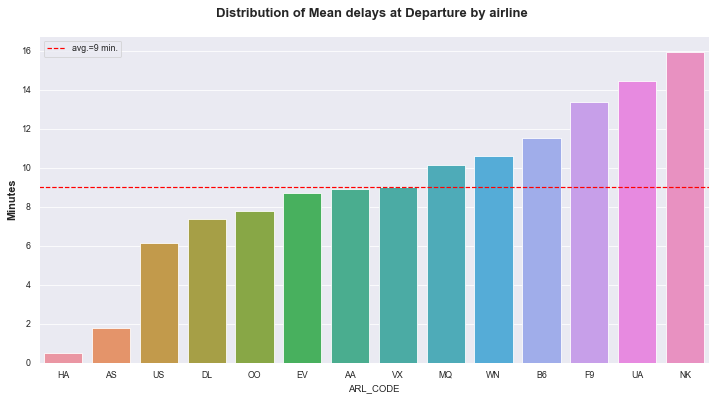

In [74]:
#how airlines compared in terms of lost time (sum of minutes) at arrival
plt.figure(figsize=(12,6))

ax=sns.barplot(x='ARL_CODE', y='mean', data=ARL_stats,
           order=ARL_stats.sort_values('mean', ascending=True).ARL_CODE)
plt.axhline(y=ARL_stats['mean'].mean(),
            color='r',
            linestyle='--',
            label='avg.=9 min.')
plt.title('Distribution of Mean delays at Departure by airline \n', fontsize=13, fontweight='bold')
plt.ylabel('Minutes', fontsize=11, fontweight='bold')
plt.legend(loc='upper left')

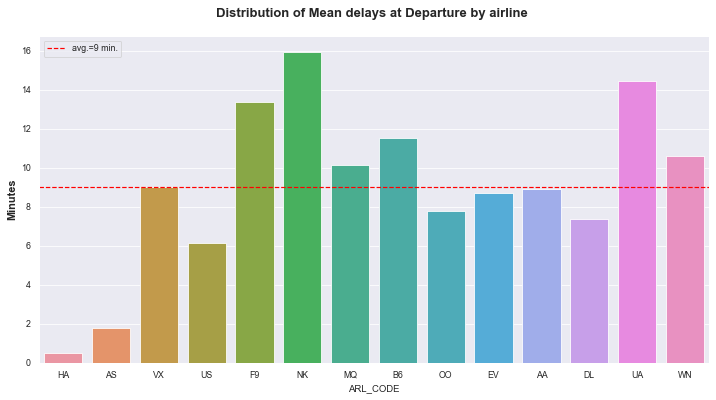

In [75]:
#how airlines compared in terms of lost time (sum of minutes) at arrival
plt.figure(figsize=(12,6))

ax=sns.barplot(x='ARL_CODE', y='mean', data=ARL_stats,
           order=ARL_stats.sort_values('sum', ascending=True).ARL_CODE)
plt.axhline(y=ARL_stats['mean'].mean(),
            color='r',
            linestyle='--',
            label='avg.=9 min.')
plt.title('Distribution of Mean delays at Departure by airline \n', fontsize=13, fontweight='bold')
plt.ylabel('Minutes', fontsize=11, fontweight='bold')
plt.legend(loc='upper left')

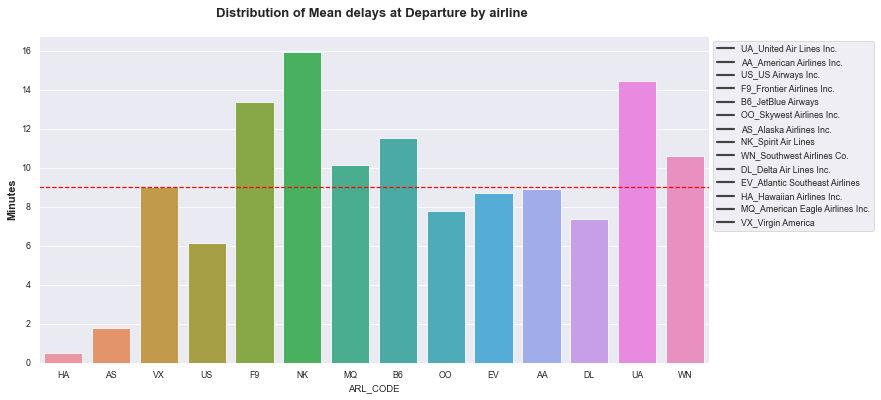

In [76]:
#how airlines compared in terms of lost time (sum of minutes) at arrival
plt.figure(figsize=(12,6))

ax=sns.barplot(x='ARL_CODE', y='mean', data=ARL_stats,
           order=ARL_stats.sort_values('sum', ascending=True).ARL_CODE)
plt.axhline(y=ARL_stats['mean'].mean(),
            color='r',
            linestyle='--',
            label='avg.=9 min.')
plt.title('Distribution of Mean delays at Departure by airline \n', fontsize=13, fontweight='bold')
plt.ylabel('Minutes', fontsize=11, fontweight='bold')
plt.legend(ARL_dictionary,loc='upper left',bbox_to_anchor=(1,1))

In [77]:
# df with delays at departure stats for each airline 
ARL_stats2 = flights_2['DEPARTURE_DELAY'].groupby(flights_2['ARL_CODE']).apply(get_stats).unstack()
ARL_stats2 = gen_stats.sort_values('count')
ARL_stats2

,min,max,count,mean,sum
ARL_CODE,,,,,
VX,-24.000,644.000,61385.000,9.023,553852.000
HA,-27.000,1433.000,76119.000,0.486,36972.000
F9,-46.000,1112.000,90290.000,13.351,1205449.000
NK,-37.000,836.000,115454.000,15.945,1840887.000
AS,-82.000,963.000,171910.000,1.786,306997.000
US,-35.000,759.000,194825.000,6.141,1196447.000
B6,-31.000,1006.000,262843.000,11.514,3026467.000
MQ,-36.000,1544.000,280282.000,10.125,2837908.000
UA,-40.000,1314.000,509534.000,14.435,7355348.000


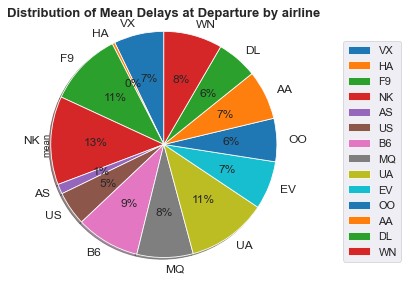

In [78]:
#how airlines compared in terms of lost time (sum of minutes) at arrival

ARL_stats2.plot.pie(y='mean',legend=True, autopct='%0.0f%%',
                   fontsize=12,shadow=True,startangle=90, radius=1.3)
plt.title('Distribution of Mean Delays at Departure by airline\n ', fontsize=13, fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(1.3,1),fontsize=11)

In [79]:
flights_2['MONTH']=flights_2['MONTH'].astype(str)
flights_2['MONTH'].replace({'1':'01','2':'02','3':'03','4':'04','5':'05','6':'06','7':'07','8':'08','9':'09'}, inplace=True)

In [80]:
#create a series of counts of each unique value
ARL_DD_size=flights_2.groupby(['ARL_CODE'])['DD_NZP_b'].value_counts().to_frame()
ARL_DD_size.rename(columns={ARL_DD_size.columns[0]:'Counts'}, inplace=True)
ARL_DD_size.reset_index(inplace=True)
ARL_DD_size

,ARL_CODE,DD_NZP_b,Counts
0,AA,DD_N,434879
1,AA,DD_Ps,125991
2,AA,DD_Pm,65707
3,AA,DD_Px,52841
4,AA,DD_Z,33517
...,...,...,...
65,WN,DD_N,586657
66,WN,DD_Ps,311730
67,WN,DD_Pm,158811
68,WN,DD_Px,93855


Text(0.5, 1.0, 'Distribution of Delays @ Departure by reasons & Airlines (counts)\n')

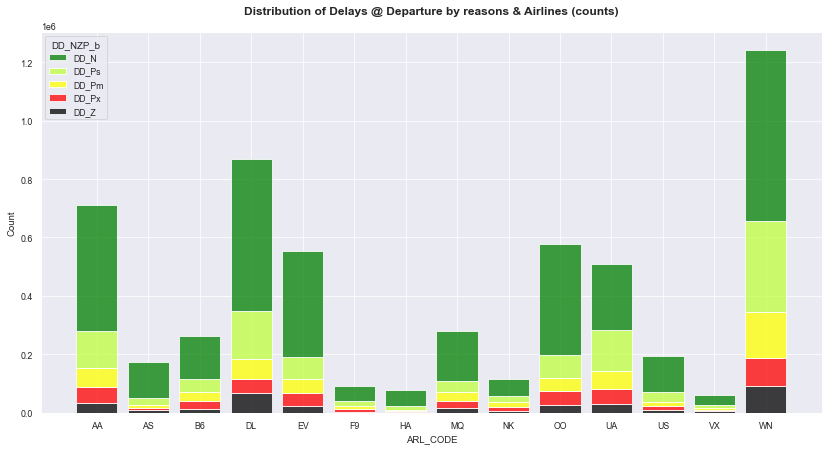

In [81]:
## create a stacked bar chart
plt.figure(figsize=(14,7))
DD_colors5={'DD_N':'green','DD_Z':'black','DD_Ps':'#C0FF3E','DD_Pm':'yellow','DD_Px':'red'}
ax = sns.histplot(data=ARL_DD_size,x='ARL_CODE',
    weights='Counts',              
    hue='DD_NZP_b',
    multiple='stack',
    palette= DD_colors5,
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.8)
plt.title('Distribution of Delays @ Departure by reasons & Airlines (counts)\n', fontsize=12, fontweight='bold')

In [82]:
#create a series of counts of each unique value
ARL_DD_size_s=flights_2.groupby(['ARL_CODE','DD_NZP'])['DEPARTURE_DELAY'].sum().to_frame()

ARL_DD_size_s.reset_index(inplace=True)

Text(0, 0.5, 'Delays in Minutes')

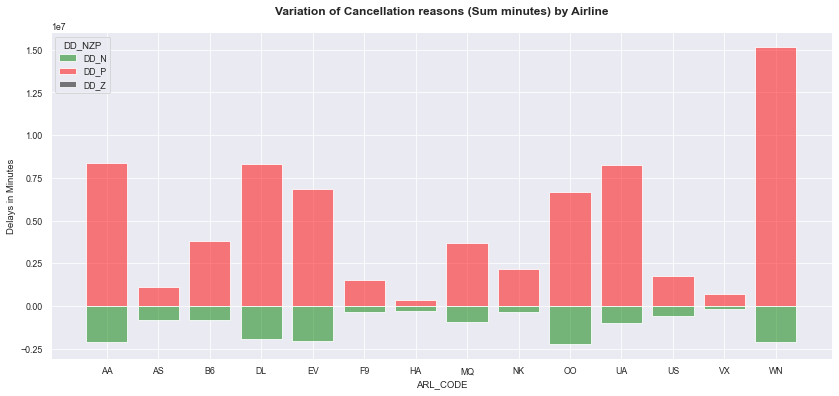

In [83]:
# create a stacked bar chart
plt.figure(figsize=(14,6))
DD_colors3={'DD_N':'green','DD_Z':'black', 'DD_P':'red'}

ax = sns.histplot(data=ARL_DD_size_s,x='ARL_CODE',
    weights='DEPARTURE_DELAY',              
    hue='DD_NZP',
    palette= DD_colors3,
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.8)
plt.title('Variation of Cancellation reasons (Sum minutes) by Airline\n', fontsize=12, fontweight='bold')
plt.ylabel('Delays in Minutes')

In [84]:
#delays by airlines and reasons
ARL_DD_reason3=flights_2.groupby(['ARL_CODE']).agg({'AIR_SYSTEM_DELAY':'sum',
                                                    'SECURITY_DELAY':'sum',
                                                    'AIRLINE_DELAY':'sum',
                                                    'LATE_AIRCRAFT_DELAY':'sum',
                                                    'WEATHER_DELAY':'sum'}).reset_index()
ARL_DD_reason3

,ARL_CODE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,AA,1760561.000,16158.000,2753994.000,2833302.000,467420.000
1,AS,301478.000,5825.000,347425.000,381417.000,38832.000
2,B6,991461.000,11417.000,1074056.000,1417496.000,115770.000
3,DL,1779383.000,3910.000,2707569.000,2136128.000,602901.000
4,EV,1687894.000,0.000,2363973.000,2628976.000,169313.000
5,F9,581234.000,0.000,346950.000,634039.000,21616.000
6,HA,6241.000,401.000,196422.000,126699.000,11429.000
7,MQ,930774.000,7049.000,1055033.000,1417073.000,402305.000
8,NK,941423.000,5147.000,471115.000,701218.000,44088.000
9,OO,1333972.000,9896.000,2043703.000,2868684.000,250325.000


In [85]:
ARL_DD_reason3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ARL_CODE             14 non-null     category
 1   AIR_SYSTEM_DELAY     14 non-null     float32 
 2   SECURITY_DELAY       14 non-null     float32 
 3   AIRLINE_DELAY        14 non-null     float32 
 4   LATE_AIRCRAFT_DELAY  14 non-null     float32 
 5   WEATHER_DELAY        14 non-null     float32 
dtypes: category(1), float32(5)
memory usage: 1.1 KB


Text(0.5, 1.0, 'Comparison of Departure Delay distributions grouped by airlines\n')

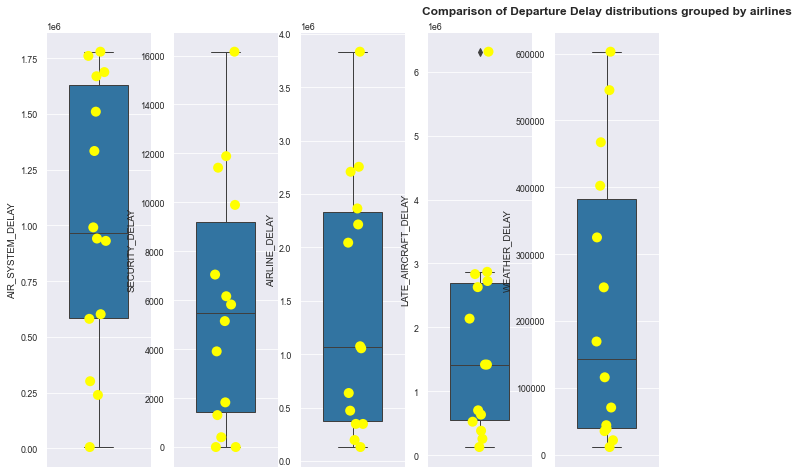

In [86]:
#comparison of distributions by delay reasons
my_new_color={'UA':'white','AA':'blueviolet','US':'#98F5FF',
         'F9':'#FF9912','B6':'#66CD00','OO':'green','AS':'#3D59AB','NK':'black',
         'WN':'red','DL':'yellow','EV':'#98F5FF','HA':'#FFF8DC','MQ':'#7FFF00',
         'VX':'pink'}
fig, axes=plt.subplots(1,5,figsize=(11,8))

sns.boxplot(ax=axes[0],y='AIR_SYSTEM_DELAY', data=ARL_DD_reason3,linewidth=1, width=0.55)
sns.stripplot(ax=axes[0],y='AIR_SYSTEM_DELAY', data=ARL_DD_reason3, size=10, color='yellow')

sns.boxplot(ax=axes[1], data=ARL_DD_reason3, y='SECURITY_DELAY',linewidth=1, width=0.55)
sns.stripplot(ax=axes[1],y='SECURITY_DELAY', data=ARL_DD_reason3, color='yellow',size=10)

sns.boxplot(ax=axes[2], data=ARL_DD_reason3, y='AIRLINE_DELAY',linewidth=1, width=0.55)
sns.stripplot(ax=axes[2],y='AIRLINE_DELAY', data=ARL_DD_reason3, color='yellow',size=10)

sns.boxplot(ax=axes[3], data=ARL_DD_reason3, y='LATE_AIRCRAFT_DELAY',linewidth=1, width=0.55)
sns.stripplot(ax=axes[3],y='LATE_AIRCRAFT_DELAY', data=ARL_DD_reason3, color='yellow',size=10)

sns.boxplot(ax=axes[4], data=ARL_DD_reason3, y='WEATHER_DELAY',linewidth=1, width=0.55)
sns.stripplot(ax=axes[4],y='WEATHER_DELAY', data=ARL_DD_reason3, color='yellow',size=10)

plt.title('Comparison of Departure Delay distributions grouped by airlines\n', fontsize=12, fontweight='bold')


Text(0.5, 1.0, 'Comparison of Departure Delay distributions grouped by airlines\n same scale')

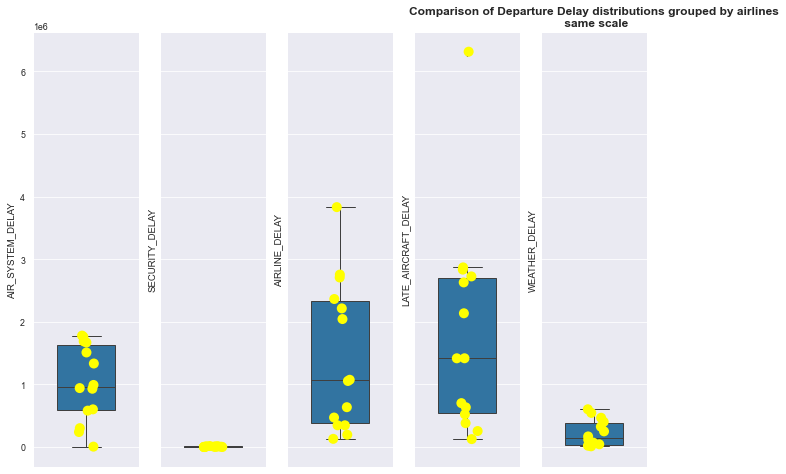

In [87]:
fig, axes=plt.subplots(1,5,figsize=(11,8), sharey=True)
my_new_color={'UA':'white','AA':'blueviolet','US':'#98F5FF',
         'F9':'#FF9912','B6':'#66CD00','OO':'green','AS':'#3D59AB','NK':'black',
         'WN':'red','DL':'yellow','EV':'#98F5FF','HA':'#FFF8DC','MQ':'#7FFF00',
         'VX':'pink'}

sns.boxplot(ax=axes[0],y='AIR_SYSTEM_DELAY', data=ARL_DD_reason3,linewidth=1, width=0.55)
sns.stripplot(ax=axes[0],y='AIR_SYSTEM_DELAY', data=ARL_DD_reason3, size=10, color='yellow')

sns.boxplot(ax=axes[1], data=ARL_DD_reason3, y='SECURITY_DELAY',linewidth=1, width=0.55)
sns.stripplot(ax=axes[1],y='SECURITY_DELAY', data=ARL_DD_reason3, color='yellow',size=10)

sns.boxplot(ax=axes[2], data=ARL_DD_reason3, y='AIRLINE_DELAY',linewidth=1, width=0.55)
sns.stripplot(ax=axes[2],y='AIRLINE_DELAY', data=ARL_DD_reason3, color='yellow',size=10)

sns.boxplot(ax=axes[3], data=ARL_DD_reason3, y='LATE_AIRCRAFT_DELAY',linewidth=1, width=0.55)
sns.stripplot(ax=axes[3],y='LATE_AIRCRAFT_DELAY', data=ARL_DD_reason3, color='yellow',size=10)

sns.boxplot(ax=axes[4], data=ARL_DD_reason3, y='WEATHER_DELAY',linewidth=1, width=0.55)
sns.stripplot(ax=axes[4],y='WEATHER_DELAY', data=ARL_DD_reason3, color='yellow',size=10)

plt.title('Comparison of Departure Delay distributions grouped by airlines\n same scale', fontsize=12, fontweight='bold')

Text(0.5, 1.0, 'Comparison of Departure Delay distributions grouped by airlines\ng')

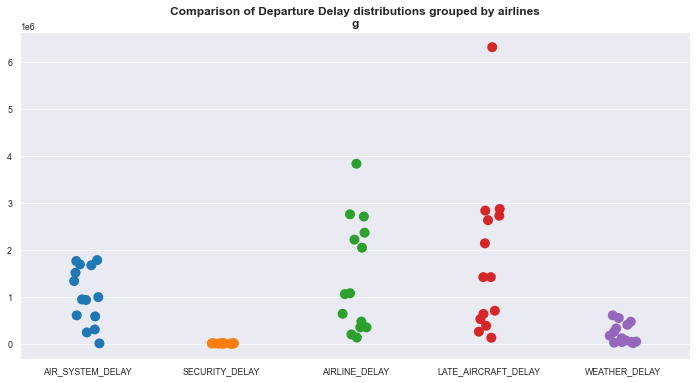

In [88]:
plt.figure(figsize=(12,6))
sns.stripplot(data=ARL_DD_reason3.drop('ARL_CODE',axis=1), size=10)
plt.title('Comparison of Departure Delay distributions grouped by airlines\ng', fontsize=12, fontweight='bold')

<AxesSubplot:xlabel='AIR_SYSTEM_DELAY', ylabel='ARL_CODE'>

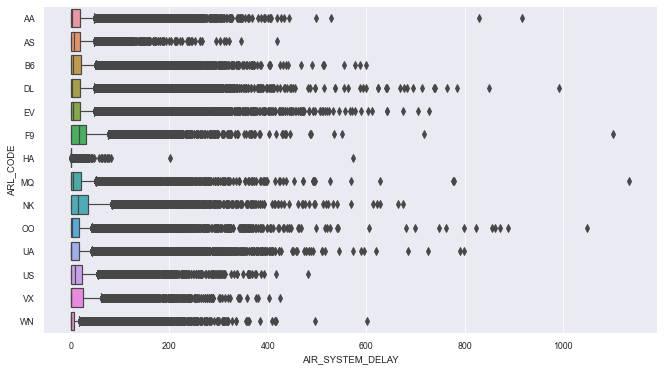

In [89]:
plt.figure(figsize=(11,6))
sns.boxplot(y='ARL_CODE',x='AIR_SYSTEM_DELAY', data=flights_2)

In [90]:
ARL_DD_reason2=flights_2.groupby(['ARL_CODE']).agg({'AIR_SYSTEM_DELAY':'value_counts',
                                                    'SECURITY_DELAY':'value_counts',
                                                    'AIRLINE_DELAY':'value_counts',
                                                    'LATE_AIRCRAFT_DELAY':'value_counts',
                                                    'WEATHER_DELAY':'value_counts'}).reset_index()
ARL_DD_reason2

,level_0,level_1,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,AA,0.000,59896.000,129548.000,61623.000,72689.000,120312.000
1,AA,1.000,2528.000,41.000,2549.000,805.000,188.000
2,AA,2.000,2402.000,26.000,2398.000,792.000,228.000
3,AA,3.000,2359.000,27.000,2205.000,811.000,239.000
4,AA,4.000,2274.000,17.000,1939.000,861.000,214.000
...,...,...,...,...,...,...,...
7442,WN,602.000,1.000,nan,1.000,nan,nan
7443,WN,604.000,nan,nan,nan,nan,1.000
7444,WN,614.000,nan,nan,1.000,nan,nan
7445,WN,628.000,nan,nan,1.000,nan,nan


Text(0, 0.5, 'Counts')

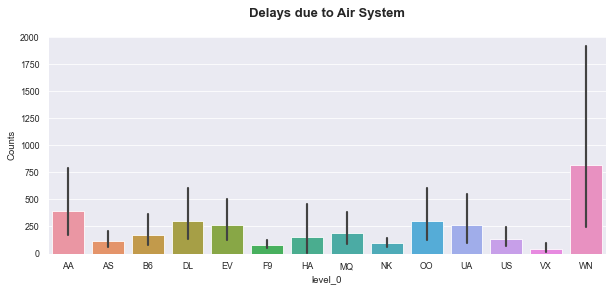

In [91]:
#1. comparison of delay reasons by airline
plt.figure(figsize=(10,4))
sns.barplot(x='level_0', y='AIR_SYSTEM_DELAY', data=ARL_DD_reason2)
plt.title('Delays due to Air System\n', fontsize=13, fontweight='bold')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

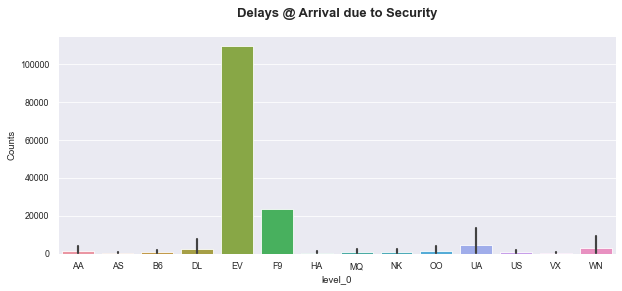

In [92]:
#2. comparison of delay reasons by airline
plt.figure(figsize=(10,4))
sns.barplot(x='level_0', y='SECURITY_DELAY', data=ARL_DD_reason2)
plt.title('Delays @ Arrival due to Security\n', fontsize=13, fontweight='bold')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

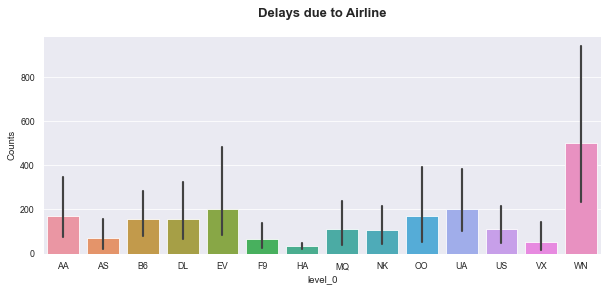

In [93]:
#3.comparison of delay reasons by airline
plt.figure(figsize=(10,4))
sns.barplot(x='level_0', y='AIRLINE_DELAY', data=ARL_DD_reason2)
plt.title('Delays due to Airline\n', fontsize=13, fontweight='bold')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

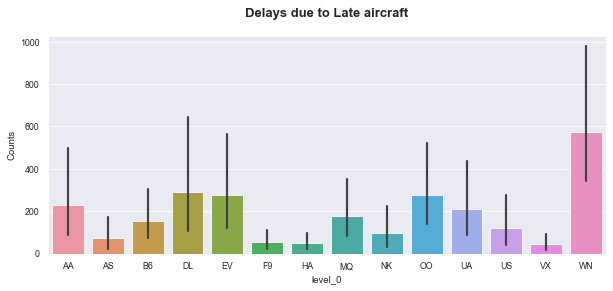

In [94]:
#4.comparison of delay reasons by airline
plt.figure(figsize=(10,4))
sns.barplot(x='level_0', y='LATE_AIRCRAFT_DELAY', data=ARL_DD_reason2)
plt.title('Delays due to Late aircraft\n', fontsize=13, fontweight='bold')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

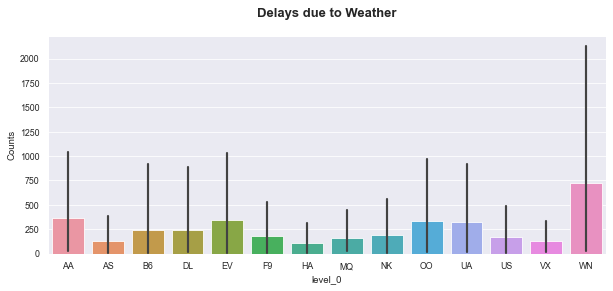

In [95]:
#5. comparison of delay reasons by airline
plt.figure(figsize=(10,4))
sns.barplot(x='level_0', y='WEATHER_DELAY', data=ARL_DD_reason2)
plt.title('Delays due to Weather\n', fontsize=13, fontweight='bold')
plt.ylabel('Counts')

Text(0.5, 1.0, 'Distribution of Delays @ Departure by reasons (counts)\n')

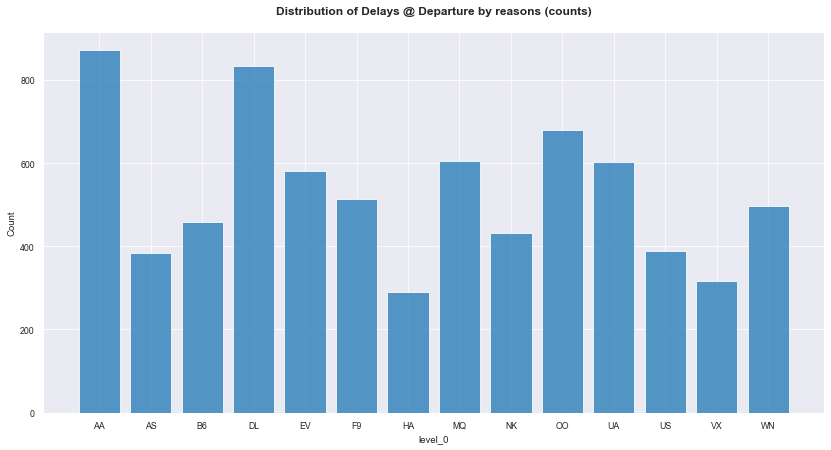

In [96]:
## create a stacked bar chart; NOT SURE WHAT IT MEASN or SHOWS
plt.figure(figsize=(14,7))
DD_colors5={'green','black','#C0FF3E','yellow','red'}
ax = sns.histplot(ARL_DD_reason2,x='level_0',
    multiple='stack', palette="light:m_r",
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.8)
plt.title('Distribution of Delays @ Departure by reasons (counts)\n', fontsize=12, fontweight='bold')

In [97]:
# create a column for delays above 500 minutes
DD_bins = lambda x:((0,1)[x > 500])
flights_2['DD_500']=flights_2['DEPARTURE_DELAY'].apply(DD_bins)

In [98]:
#creat a df excluding delays >500 only
DD_To500=flights_2[flights_2['DD_500']==0]

#creat a df with delays >500 only
DD_Above500=flights_2[flights_2['DD_500']==1]

Text(0.5, 1.0, 'Delays > 500 @ Departure vs. @Arrival\n')

<Figure size 288x288 with 0 Axes>

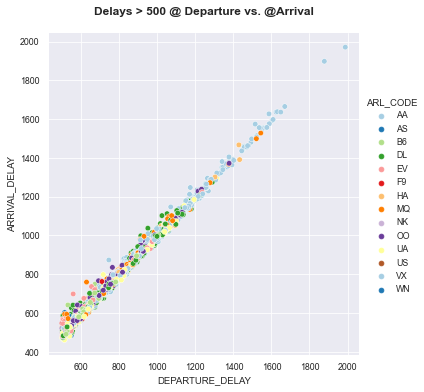

In [99]:
#regression plot for delays at departure vs. delays at arrival
plt.figure(figsize=(4,4))
sns.set_context('paper',font_scale=1)
sns.relplot(x='DEPARTURE_DELAY', y='ARRIVAL_DELAY',
            kind='scatter', data=DD_Above500, hue='ARL_CODE', palette='Paired', s=30)
plt.title('Delays > 500 @ Departure vs. @Arrival\n',size=12, fontweight='bold')

Text(0.5, 1.0, 'Delays > 500 @ Departure vs. @Arrival\n')

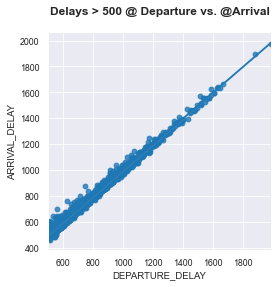

In [100]:
#regression plot for delays at departure vs. delays at arrival
plt.figure(figsize=(4,4))
sns.set_context('paper',font_scale=1)
sns.regplot(x='DEPARTURE_DELAY', y='ARRIVAL_DELAY',data=DD_Above500)
plt.title('Delays > 500 @ Departure vs. @Arrival\n',size=12, fontweight='bold')

In [101]:
col1=DD_Above500['DEPARTURE_DELAY']
col2=DD_Above500['ARRIVAL_DELAY']
correlation=col1.corr(col2)
correlation

0.9961382417915114

Text(12.61519366666667, 0.5, 'Minutes')

<Figure size 288x288 with 0 Axes>

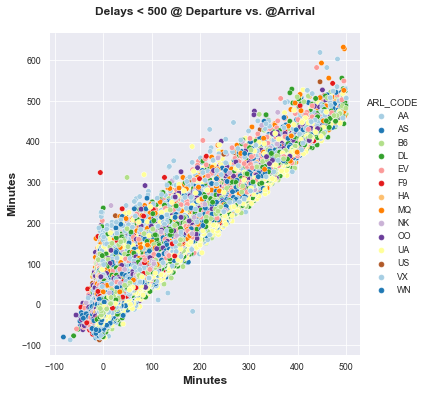

In [102]:
#regression plot for delays at departure vs. delays at arrival
plt.figure(figsize=(4,4))
sns.set_context('paper',font_scale=1)
sns.relplot(x='DEPARTURE_DELAY', y='ARRIVAL_DELAY',
            kind='scatter', data=DD_To500, hue='ARL_CODE', palette='Paired', s=30)
plt.title('Delays < 500 @ Departure vs. @Arrival\n',size=12, fontweight='bold')
plt.xlabel('Minutes',size=12, fontweight='bold')
plt.ylabel('Minutes',size=12, fontweight='bold')

In [103]:
col1=DD_To500['DEPARTURE_DELAY']
col2=DD_To500['ARRIVAL_DELAY']
correlation=col1.corr(col2)
correlation

0.935234231227482

Text(257.40074802083336, 0.5, 'Minutes')

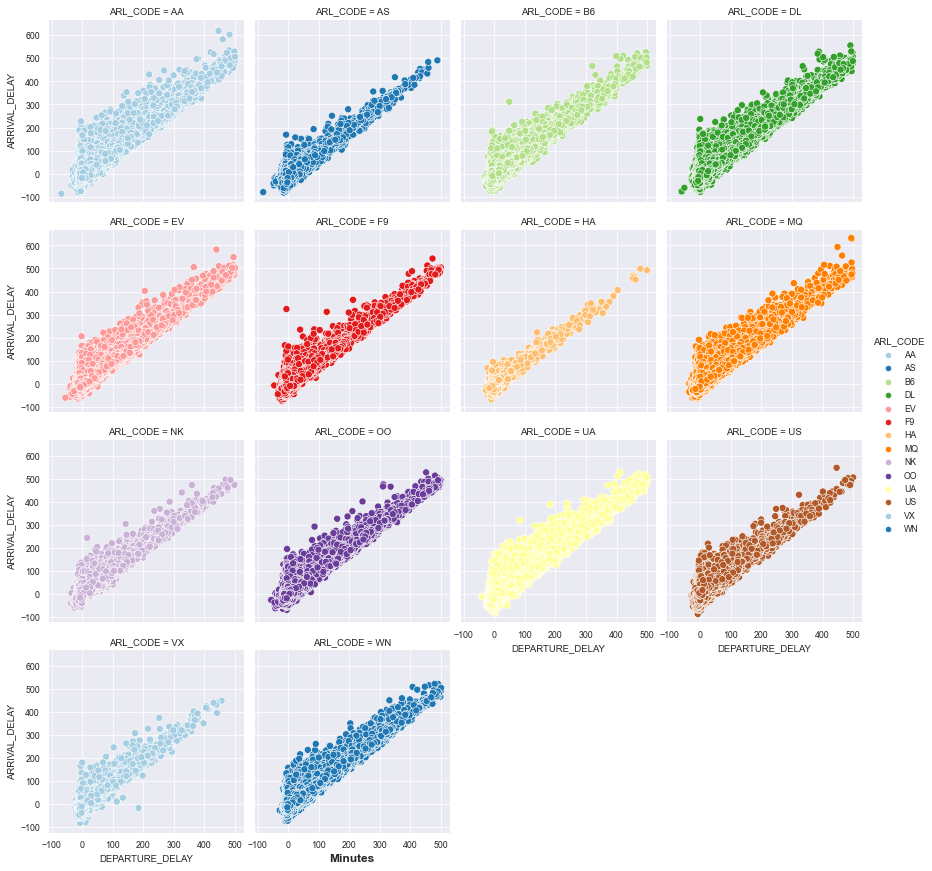

In [104]:
sns.set_context('paper',font_scale=1)
sns.relplot(x='DEPARTURE_DELAY', y='ARRIVAL_DELAY', kind='scatter',
            data=DD_To500, hue='ARL_CODE', palette='Paired',
            s=50, col='ARL_CODE', col_wrap=4, height=3)
plt.xlabel('Minutes',size=12, fontweight='bold')
plt.ylabel('Minutes',size=12, fontweight='bold')